### Install project

In [1]:
!git clone https://github.com/kornelro/cv_project.git

Cloning into 'cv_project'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 413 (delta 47), reused 105 (delta 30), pack-reused 278
Receiving objects: 100% (413/413), 94.77 MiB | 17.65 MiB/s, done.
Resolving deltas: 100% (193/193), done.


In [2]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=14757 sha256=6b2bcc4d6cc9021bcd8f8c99c0deaf43f464c1c3ae6bd3537bc7b2fcc7f1ed50
  Stored in directory: /tmp/pip-ephem-wheel-cache-odrodpki/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src


### Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [5]:
pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-jqbijt1g
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-jqbijt1g
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 4.5MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20030 sha256=4c69f0f62769a52ddf923064d1185f09988d0653887dd87de71ff02f91b51303
  Stored in directory: /tmp/pip-ephem-wheel-cache-k_p74yp2/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [6]:
pip install stellargraph

     |████████████████████████████████| 440kB 11.5MB/s 


In [7]:
import pickle
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from classification_models.keras import Classifiers
from stellargraph.utils.history import plot_history

from src.data.make_dataset import make_dataset
from src.data.image_loaders import AerialCarsFixedSizeImageLoader
from src.data.dataset_loaders import AerialCarsDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow

# Aerial-Cars-Dataset
# ResNet50
# Pipeline: Norm

### Load dataset

In [34]:
DATA_PATH = DRIVE_PATH+'data/processed/aerial-cars-dataset/resnet/data_resnet.pickle'

In [35]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### Train ResNet50

In [36]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 5

In [37]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


input_t = K.Input(shape=(X[0].shape))
res_model = K.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t
)

for layer in res_model.layers:
    layer.trainable = False

model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='softmax'))


model.compile(
    optimizer=K.optimizers.Adam(0.001),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

Epoch 1/5
43/43 [==============================] - 10s 147ms/step - loss: 0.3105 - accuracy: 0.9115 - val_loss: 0.0656 - val_accuracy: 0.9894
Epoch 2/5
43/43 [==============================] - 5s 124ms/step - loss: 0.0491 - accuracy: 0.9922 - val_loss: 0.0534 - val_accuracy: 0.9915
Epoch 3/5
43/43 [==============================] - 5s 124ms/step - loss: 0.0152 - accuracy: 0.9957 - val_loss: 0.0613 - val_accuracy: 0.9894
Epoch 4/5
43/43 [==============================] - 5s 123ms/step - loss: 9.5678e-04 - accuracy: 0.9997 - val_loss: 0.0616 - val_accuracy: 0.9915
Epoch 5/5
43/43 [==============================] - 5s 123ms/step - loss: 3.9103e-04 - accuracy: 1.0000 - val_loss: 0.0509 - val_accuracy: 0.9915


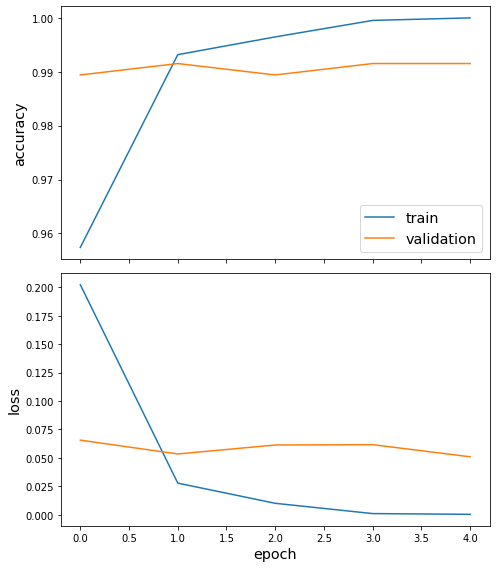

In [38]:
plot_history(history)

### Validation

In [39]:
from tqdm import tqdm
from copy import deepcopy

def validate_model(
    dataset_loader,
    input_folder_filepath,
    images_files_types,
    annotations_files_types,
    detector,
    workers = 0
):

    images = dataset_loader.load_dataset(
        input_folder_filepath,
        images_files_types,
        annotations_files_types,
        False
    )

    processed_images = []

    for image in tqdm(images):
        processed_images.append(
            detector(deepcopy(image), workers)
        )

    return processed_images

In [40]:
data = None

In [41]:
BND_BOX_SIZE = (80, 80)
STEP_SIZE = 20

dataset_loader = AerialCarsDatasetLoader(
    image_loader=AerialCarsFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.3
)

In [42]:
processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/aerial-cars-dataset/val_dev',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

  0%|          | 0/1 [00:00<?, ?it/s]

(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)


100%|██████████| 1/1 [00:10<00:00, 10.36s/it]

224
Overlap is 0.5061728395061729
Overlap is 0.06721536351165981
Overlap is 0.5061728395061729
Overlap is 0.25925925925925924
Overlap is 0.3811918914799573
Overlap is 0.3811918914799573
Overlap is 0.13122999542752628
Overlap is 0.19524462734339276
Overlap is 0.25925925925925924
Overlap is 0.13122999542752628
Overlap is 0.003200731595793324
Overlap is 0.06721536351165981
Overlap is 0.2562109434537418
Overlap is 0.7530864197530864
Overlap is 0.3811918914799573
Overlap is 0.7530864197530864
Overlap is 0.13122999542752628
Overlap is 0.006249047401310776
Overlap is 0.3811918914799573
Overlap is 0.19524462734339276
Overlap is 0.5671391556165218
Overlap is 0.25925925925925924
Overlap is 0.5671391556165218
Overlap is 0.7530864197530864
Overlap is 0.5671391556165218
Overlap is 0.3811918914799573
Overlap is 0.5061728395061729
Overlap is 0.7530864197530864
Overlap is 0.009297363206828228
Overlap is 0.012345679012345678
Overlap is 0.009297363206828228
Overlap is 0.006249047401310776
Overlap is 0.1

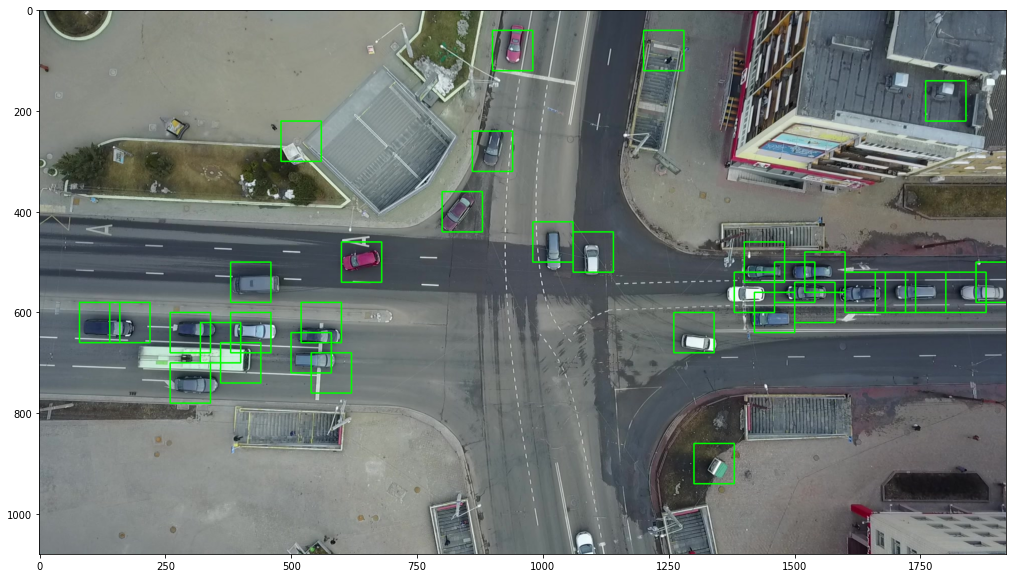

In [43]:
plt.figure(figsize=(20,10))
plt.imshow(processed_images[0][0])